<a href="https://colab.research.google.com/github/Masterpiece-Image/Transformers-Train/blob/main/RainGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import glob
import os
import argparse

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from re import L

In [2]:

def gen_pluie(img, longueur_pluie=10, angle_pluie=0, largeur_pluie=1, SNR = 80):

    l,c = img.shape

    #calcul du sigma a partir du SNR
    moy = np.mean(img)
    cop = np.copy(img)

    p_sig = np.sum((cop-moy)**2)/(l*c)
    var = np.var(img)
    sig = var*10**(-SNR/10)/(longueur_pluie*largeur_pluie)

    #génère matrice bruit initiale avec une distribution uniforme
    noise = np.random.normal(0, sig, img.shape)


    #On garde que les valeurs supérieure a 256-seuil, les autres sont mises à zéros
    # seuil = seuil * 0.01
    # noise[np.where(noise < (sig/2))] = 0
    # noise[np.where(noise > (sig/2))] = 255

    print(moy,p_sig,sig,var)

    #on utilise un filtre afin de flouter les pixels initiaux de pluie
    k = np.array([[0, 0.1, 0],
                  [0.1, 8, 0.1],
                  [0, 0.1, 0]])

    noise = cv2.filter2D(noise, -1, k)

    #on génère la matrice représentant un trait de pluie suivant les critère longeur_pluie, angle_pluie
    trans = cv2.getRotationMatrix2D((longueur_pluie / 2, longueur_pluie / 2), angle_pluie - 45, 1 - longueur_pluie / 100.0)
    #on crée notre matrice diagonale qui représente notre "trait" de pluie
    dig = np.diag(np.ones(longueur_pluie))
    #on lui applique la transformation affine avec la matrice de rotation crée juste avant afin d'avoir la bonne longueur et le bon angle
    k = cv2.warpAffine(dig, trans, (longueur_pluie, longueur_pluie))
    #on ajoute du flou afin que la pluie soit plus "épaisse"
    k = cv2.GaussianBlur(k, (largeur_pluie,largeur_pluie), 0)
    flou = cv2.filter2D(noise, -1, k)
    filtre_pluie = np.array(flou, dtype=np.float32)


    img_bruitee = img.copy()

    mean = np.mean(img_bruitee)
    std = np.std(img_bruitee)
    img_bruitee = (img_bruitee - mean) / std

    img_bruitee[:,:] = img_bruitee[:,:] + (filtre_pluie[:,:])

    return img_bruitee*std+mean


In [8]:
def gen_pluie_seuil(img, seuil=20, longueur_pluie=10, angle_pluie=0, largeur_pluie=1, SNR = 80):

    #calcul du sigma a partir du SNR
    moy = np.mean(img[:])
    sig = moy*10**(SNR/10)

    #génère matrice bruit initiale avec une distribution uniforme
    noise = np.random.normal(0, sig, img.shape[0:2])


    #On garde que les valeurs supérieure a 256-seuil, les autres sont mises à zéros
    seuil = seuil * 0.01
    noise[np.where(noise < (256 - seuil))] = 0

    #return noise

    #on utilise un filtre afin de flouter les pixels initiaux de pluie
    k = np.array([[0, 0.1, 0],
                  [0.1, 8, 0.1],
                  [0, 0.1, 0]])

    noise = cv2.filter2D(noise, -1, k)

    #on génère la matrice représentant un trait de pluie suivant les critère longeur_pluie, angle_pluie
    trans = cv2.getRotationMatrix2D((longueur_pluie / 2, longueur_pluie / 2), angle_pluie - 45, 1 - longueur_pluie / 100.0)
    #on crée notre matrice diagonale qui représente notre "trait" de pluie
    dig = np.diag(np.ones(longueur_pluie))
    #on lui applique la transformation affine avec la matrice de rotation crée juste avant afin d'avoir la bonne longueur et le bon angle
    k = cv2.warpAffine(dig, trans, (longueur_pluie, longueur_pluie))
    #on ajoute du flou afin que la pluie soit plus "épaisse"
    k = cv2.GaussianBlur(k, (largeur_pluie,largeur_pluie), 0)
    flou = cv2.filter2D(noise, -1, k)
    cv2.normalize(flou, flou, 0, 255, cv2.NORM_MINMAX)
    filtre_pluie = np.array(flou, dtype=np.float32)



    #filtre_pluie = np.expand_dims(filtre_pluie, 2)
    #filtre_pluie = np.array(filtre_pluie, dtype=np.float32)

    img_bruitee = img.copy()

    img_bruitee[:,:] = img_bruitee[:,:] + (filtre_pluie[:,:])/255

    return img_bruitee

In [56]:
def pluie_sel(image,rsb_db):
    signal_level = np.max(image)
    noise_level = signal_level / (10**((rsb_db+15)/10))

    bruit = np.random.uniform(0, 1, size=image.shape)
    bruit[bruit < noise_level] = 0
    bruit[bruit > 1-noise_level] = 255


        #on utilise un filtre afin de flouter les pixels initiaux de pluie
    k = np.array([[0, 0.1, 0],
                  [0.1, 8, 0.1],
                  [0, 0.1, 0]])

    noise = cv2.filter2D(bruit, -1, k)

    longueur_pluie=30
    angle_pluie=20
    largeur_pluie=3

    #on génère la matrice représentant un trait de pluie suivant les critère longeur_pluie, angle_pluie
    trans = cv2.getRotationMatrix2D((longueur_pluie / 2, longueur_pluie / 2), angle_pluie - 45, 1 - longueur_pluie / 100.0)
    #on crée notre matrice diagonale qui représente notre "trait" de pluie
    dig = np.diag(np.ones(longueur_pluie))
    #on lui applique la transformation affine avec la matrice de rotation crée juste avant afin d'avoir la bonne longueur et le bon angle
    k = cv2.warpAffine(dig, trans, (longueur_pluie, longueur_pluie))
    #on ajoute du flou afin que la pluie soit plus "épaisse"
    k = cv2.GaussianBlur(k, (largeur_pluie,largeur_pluie), 0)
    flou = cv2.filter2D(noise, -1, k)
    cv2.normalize(flou, flou, 0, 255, cv2.NORM_MINMAX)
    filtre_pluie = np.array(flou, dtype=np.float32)





    image_bruite = cv2.add(image, filtre_pluie.astype(np.uint8))
    return image_bruite

97.55362955729167 3497.914441578918 0.009217813913154469 3497.914441578918
263.5937909425239


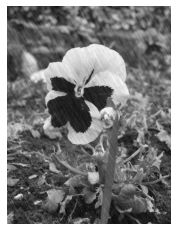

In [61]:
img = cv2.imread("2.jpg", 0);


longueur_pluie = 40 #10 - 60
angle_pluie = 30
largeur_pluie = 3

SNR = 35
img_bruitee = gen_pluie(img, longueur_pluie, angle_pluie, largeur_pluie, SNR)

plt.imshow(img_bruitee, cmap='gray')
plt.axis('off')
cv2.imwrite('img_bruitee.jpg', img_bruitee)

print(np.max(img_bruitee))





True

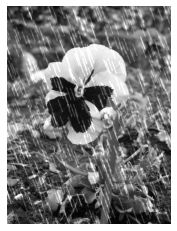

In [63]:
img_bruitee = pluie_sel(img,SNR)

plt.imshow(img_bruitee, cmap='gray')
plt.axis('off')
cv2.imwrite('img_bruitee3.jpg', img_bruitee)

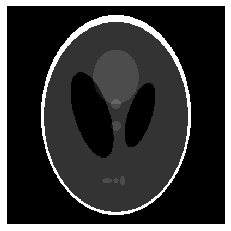

In [ ]:
plt.imshow(img,cmap='gray',interpolation='nearest')
plt.axis('off')
plt.savefig('img.jpg', bbox_inches='tight', pad_inches=0)